In [1]:
import os
from pathlib import Path, PurePath, PureWindowsPath, PurePosixPath
import sys
import glob
import random
import time
import re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from sklearn.metrics import roc_auc_score, roc_curve, det_curve
from sklearn.metrics import accuracy_score, cohen_kappa_score,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay,RocCurveDisplay
import joblib
import pickle
import warnings
import scipy.stats
from scipy.stats import chi2
sys.path.append('../radiomics_pipeline/')
sys.path.append('../radiomics_pipeline/utilities/')
import pandas as pd
import matplotlib.pyplot as plt
from training.trainer import learning
from learning_algorithms.models import decicion_tree, lr, svm, svc
from learning_algorithms.models import random_forest, naive
from learning_algorithms.models import knn, adab_tree, lda, qda
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, DetCurveDisplay
from sklearn.metrics import classification_report, precision_recall_curve
from data_loader.feature_loader import load_radiomic_set
from utilities.feature_tools import feature_normalization, data_shuffling
from statsmodels.stats.contingency_tables import mcnemar

In [2]:
def drop_feat_with_low_var(df, CENTERED_PERCENT=0.8, LOW_VAR_VAL=0.2):
    print ( "\nStart drop low var features function")
    features_list = df.columns.tolist()
#    features_list.remove('Diagnosis')
    
    low_var_features_list = []
    categorical_features_list = []
    numerical_features_list = []

    #dividing the features into categorical and numerical
    for ftr in features_list:
        if df[ftr].nunique()<=20:
            categorical_features_list.append(ftr)
        else:
            numerical_features_list.append(ftr)

    #categorical features with low variance
    for ftr in categorical_features_list:
        if df[ftr].value_counts(normalize = True).max() >= CENTERED_PERCENT:
            low_var_features_list.append(ftr)

    #numerical features with low variance
    for ftr in numerical_features_list:
        if df[ftr].var() <= LOW_VAR_VAL:
            low_var_features_list.append(ftr)          

    df.drop(low_var_features_list,axis=1,inplace=True)
    
    print("{} features dropped due to low variance".format(len(low_var_features_list)))
    print("{} features in data-set after low var drop".format(df.shape[1]))
    return df

def kappa_score(df_1_value,df_2_value):
    k_score =cohen_kappa_score(df_1_value,df_2_value, weights = 'linear')
    #k_score =cohen_kappa_score(df_1_value,df_2_value)
    print('kappa: {}'.format(k_score))
    bootstraps(df_1_value,df_2_value, function = 'kappa')
    
def test_clf(clf, test_set, test_label, *argv):
    y_val = test_label
    test_data = test_set
    y_pred = clf.predict(test_data)
    #y_prob = clf.best_estimator_.predict_proba(test_data)
    y_prob = clf.predict_proba(test_data)
    
    if argv != False:
        print(classification_report(y_val, y_pred))
        print('the accuracy score of the classifier is {}'.format(accuracy_score(y_val, y_pred)))
        bootstraps(y_val, y_pred,function='ACC')
        print('the kappa score of the classifier is {}'.format(cohen_kappa_score(y_val, y_pred, weights = 'linear')))
        bootstraps(y_val, y_pred,function='kappa')

    if len(np.unique(y_val)) == 2:
        scores = y_prob[:,1]
        fpr, tpr, threshold = roc_curve(y_val, scores)
        auc = roc_auc_score(y_val, scores)
        print('AUC: {}'.format(auc))
        bootstraps(y_val,scores,function = 'AUC')
        #RocCurveDisplay.from_estimator(clf, test_data, y_val, )
    else:
        fpr, tpr, threshold = [], [], []
    
    #ConfusionMatrixDisplay.from_estimator(clf, test_data, y_val, xticks_rotation="vertical")
    cm = confusion_matrix(test_label, y_pred)
    #cm_display = ConfusionMatrixDisplay(cm).plot()
  
    return cm, y_pred, y_prob,  fpr, tpr, threshold

def bootstraps(y_label,y_prob,function):
    n_bootstraps = 5000
    rng_seed = 42  # control reproducibility
    bootstrapped_scores = []

    rng = np.random.RandomState(rng_seed)
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(y_prob), len(y_prob))
        if len(np.unique(y_label[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue
        if function == 'AUC':
            score = roc_auc_score(y_label[indices], y_prob[indices])
        elif function == 'kappa':
            score = cohen_kappa_score(y_label[indices], y_prob[indices], weights = 'linear')
            #score = cohen_kappa_score(y_label[indices], y_prob[indices])
        elif function == 'ACC':
            score = accuracy_score(y_label[indices], y_prob[indices])
        
        bootstrapped_scores.append(score)
        #print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
        
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()

    # Computing the lower and upper bound of the 90% confidence interval
    # You can change the bounds percentiles to 0.025 and 0.975 to get
    # a 95% confidence interval instead.
    confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    print("Confidence interval for the {} score: [{:0.3f} - {:0.3}]".format(function,
        confidence_lower, confidence_upper))

def mcnemar_test(y_test, y_1, y_2):
    a = sum(np.logical_and((y_1 == y_test),(y_2 == y_test)))
    b = sum(np.logical_and((y_1 == y_test),(y_2 != y_test)))
    c = sum(np.logical_and((y_1 != y_test),(y_2 == y_test)))
    d = sum(np.logical_and((y_1 != y_test),(y_2 != y_test)))
    
    table = [[a,b],[c,d]]
    
    result = mcnemar(table, exact=False, correction=True)
    
    return result.statistic, result.pvalue

def majority_vote(*arg):
    majority = []
    for x in zip(*arg):
        majority.append(Counter(x).most_common(1)[0][0])
    return np.array(majority)

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        precents = np.around(np.true_divide(cf,cf.sum( axis = 1,  keepdims = True)),3).flatten()
        group_percentages = ["{0:0.1f}%\n".format(value*100) for value in  precents]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)
        
def plot_cm(Label_1,Label_2,num_classes,file_name=False):
    
    cm = confusion_matrix(Label_1, Label_2)

    #cm_display = ConfusionMatrixDisplay(cm).plot()
    if num_classes == 4:
        categories = ['Fatty', 'Scattered', 'Heterogeneous', 'Extreme']
    elif num_classes == 2:
        categories = ['Non-dense', 'Dense']
    elif num_classes == 'exd':
        categories = ['Moderately dense', 'Extremely Dense']

    make_confusion_matrix(cm,group_names=None,
                              categories=categories,
                              count=True,
                              percent=True,
                              cbar=False,
                              xyticks=True,
                              xyplotlabels=True,
                              sum_stats=False,
                              figsize=(6,5),
                              cmap='Blues',
                              title=None)
    if file_name:
        plt.savefig(file_name, dpi = 600, format = 'tif')

In [3]:
########
# load data
reader_1_df = pd.read_excel(r"DATA_FOR_TEST_NO_PROTHESIS_WITHPATH.xlsx")
reader_2_df = pd.read_excel("BD_TESTSET_READER_AM.xlsx")
reader_3_df = pd.read_excel("BD_TESTSET_READER_MW.xlsx")
reader_4_df = pd.read_excel("BD_TESTSET_READER_SK.xlsx")
reader_5_df = pd.read_excel("BD_TESTSET_READER_STAMS.xlsx")


DL_pred_2 = pd.read_excel("dl_pred_2.xlsx")

DL_pred_val_4 = pd.read_csv("dl_pred_val_4.csv")
DL_pred_4 = pd.read_csv("dl_pred_test_4.csv")

In [4]:
######
# remove unqualified patients
reader_1_df = reader_1_df.drop([138,226,239])
reader_2_df = reader_2_df.drop([138,226,239])
reader_3_df = reader_3_df.drop([138,226,239])
reader_4_df = reader_4_df.drop([138,226,239])
reader_5_df = reader_5_df

DL_pred_2 = DL_pred_2.drop([225,238])
DL_pred_4 = DL_pred_4.drop([225,238])

In [5]:
#####
# generate consensus
l_1 = np.array(reader_1_df.label.values)
l_2 = np.array(reader_2_df.label.values)
l_3 = np.array([int(x) for x in reader_3_df.label.values])
l_4 = np.array(reader_4_df.label.values)
l_5 = np.array(reader_5_df.label.values)

l_1_b = np.array([0 if x < 2 else 1 for x in reader_1_df.label.values])
l_2_b = np.array([0 if x < 2 else 1 for x in reader_2_df.label.values])
l_3_b = np.array([0 if x < 2 else 1 for x in reader_3_df.label.values])
l_4_b = np.array([0 if x < 2 else 1 for x in reader_4_df.label.values])
l_5_b = np.array([0 if x < 2 else 1 for x in reader_5_df.label.values])

l_1_exd = np.array([0 if x < 3 else 1 for x in reader_1_df.label.values])
l_2_exd = np.array([0 if x < 3 else 1 for x in reader_2_df.label.values])
l_3_exd = np.array([0 if x < 3 else 1 for x in reader_3_df.label.values])
l_4_exd = np.array([0 if x < 3 else 1 for x in reader_4_df.label.values])
l_5_exd = np.array([0 if x < 3 else 1 for x in reader_5_df.label.values])

dl_2 = DL_pred_2.Prediction.values
dl_4 = DL_pred_4.Prediction.values

dl_exd_pred = np.array([1 if x >= 0.26174977 else 0 for x in dl_4])

consensus_4 = majority_vote(l_1,l_2,l_3,l_4, l_5)
    
consensus_2 = majority_vote(l_1_b,l_2_b,l_3_b,l_4_b, l_5_b)

consensus_exd = majority_vote(l_1_exd,l_2_exd,l_3_exd,l_4_exd, l_5_exd)

In [90]:
Counter(consensus_4), Counter(consensus_2), Counter(consensus_exd)

(Counter({2: 79, 3: 41, 1: 101, 0: 37}),
 Counter({1: 120, 0: 138}),
 Counter({0: 217, 1: 41}))

In [7]:
c = Counter(consensus_4)
print(c)
for x, i in c.items():
    print(x, i)
    print(i/258)

Counter({1: 100, 2: 93, 0: 35, 3: 30})
2 93
0.36046511627906974
3 30
0.11627906976744186
1 100
0.3875968992248062
0 35
0.13565891472868216


In [22]:
c = Counter(consensus_2)
print(c)
for x, i in c.items():
    print(x, i)
    print(i/258)

Counter({0: 135, 1: 123})
1 123
0.47674418604651164
0 135
0.5232558139534884


In [23]:
c = Counter(consensus_exd)
print(c)
for x, i in c.items():
    print(x, i)
    print(i/258)

Counter({0: 228, 1: 30})
0 228
0.8837209302325582
1 30
0.11627906976744186


In [24]:
c = Counter(dl_4)
print(c)
for x, i in c.items():
    print(i/258)

Counter({2: 120, 1: 89, 3: 26, 0: 23})
0.46511627906976744
0.3449612403100775
0.10077519379844961
0.08914728682170543


In [25]:
c = Counter(dl_2)
print(c)
for x, i in c.items():
    print(i/258)

Counter({0: 133, 1: 125})
0.4844961240310077
0.5155038759689923


In [26]:
c = Counter(dl_exd_pred)
print(c)
for x, i in c.items():
    print(i/258)

Counter({1: 235, 0: 23})
0.9108527131782945
0.08914728682170543


## CM Rx vs Consensus 4-categories

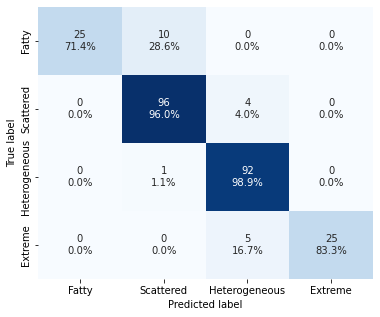

In [27]:
plot_cm(consensus_4,l_1,4,file_name = 'CM_L1_CONSENSUS_4.tif')

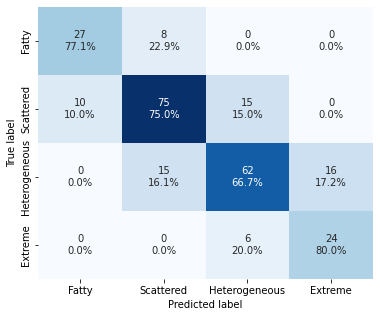

In [18]:
plot_cm(consensus_4,l_2,4,file_name = 'CM_L2_CONSENSUS_4.tif')

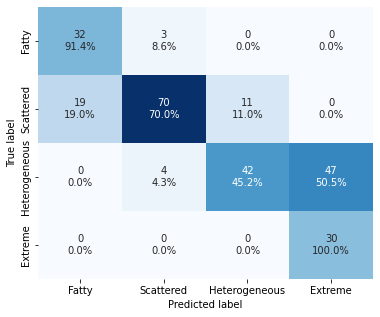

In [19]:
plot_cm(consensus_4,l_3,4,file_name = 'CM_L3_CONSENSUS_4.tif')

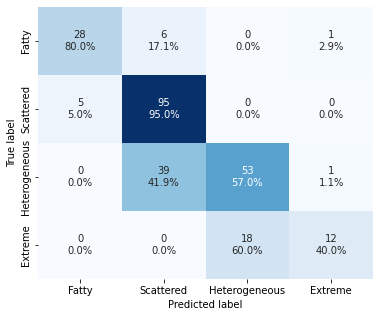

In [20]:
plot_cm(consensus_4,l_4,4,file_name = 'CM_L4_CONSENSUS_4.tif')

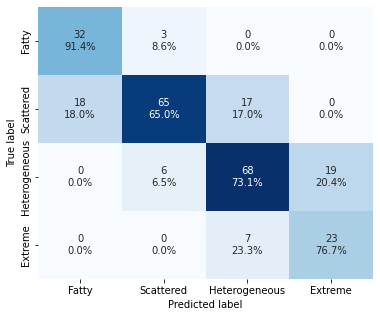

In [21]:
plot_cm(consensus_4,l_5,4,file_name = 'CM_L5_CONSENSUS_4.tif')

## Deep learning classification results

In [28]:
acc = accuracy_score(consensus_2, dl_2)
auc = roc_auc_score(consensus_2,DL_pred_2.Probility.values)
k_score = cohen_kappa_score(consensus_2,DL_pred_2.Prediction.values, weights = 'linear')
print('ACC: {}'.format(acc))
bootstraps(consensus_2,DL_pred_2.Prediction.values,function = 'ACC')
print('AUC: {}'.format(auc))
bootstraps(consensus_2,DL_pred_2.Probility.values,function = 'AUC')
print('kappa: {}'.format(k_score))
bootstraps(consensus_2,DL_pred_2.Prediction.values,function = 'kappa')

ACC: 0.8914728682170543
Confidence interval for the ACC score: [0.853 - 0.93]
AUC: 0.9548931044866004
Confidence interval for the AUC score: [0.931 - 0.975]
kappa: 0.7826322440873804
Confidence interval for the kappa score: [0.703 - 0.857]


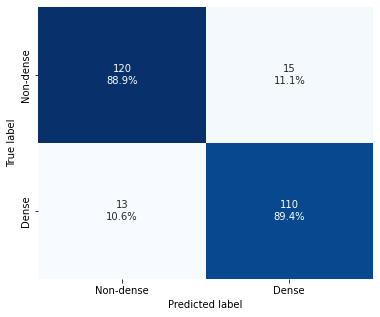

In [23]:
plot_cm(consensus_2, dl_2, 2, 'DL_CM_2_TEST.tif')

plt.savefig('DL_CM_2_TEST.tif', dpi = 600, format = 'tif')

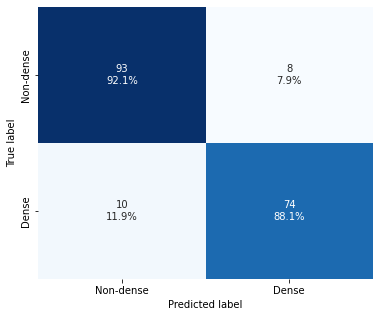

In [25]:
cm = np.array([[93,  8],
       [ 10, 74]])
#cm_display = ConfusionMatrixDisplay(cm).plot()

categories = ['Non-dense', 'Dense']

make_confusion_matrix(cm,group_names=None,
                          categories=categories,
                          count=True,
                          percent=True,
                          cbar=False,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=False,
                          figsize=(6,5),
                          cmap='Blues',
                          title=None)
plt.savefig('DL_CM_2_VAL.tif', dpi = 600, format = 'tif')

In [26]:
acc = accuracy_score(consensus_4, dl_4)
#auc = roc_auc_score(DL_pred_4.Label.values,DL_pred_4.Probility.values)
k_score = cohen_kappa_score(consensus_4, dl_4, weights = 'linear')
print('ACC: {}'.format(acc))
bootstraps(consensus_4, dl_4,function = 'ACC')
# print('AUC: {}'.format(auc))
# bootstraps(DL_pred_2.Label.values,DL_pred_2.Probility.values,function = 'AUC')
print('kappa: {}'.format(k_score))
bootstraps(consensus_4, dl_4,function = 'kappa')

ACC: 0.6705426356589147
Confidence interval for the ACC score: [0.612 - 0.725]
kappa: 0.624196356817573
Confidence interval for the kappa score: [0.549 - 0.693]


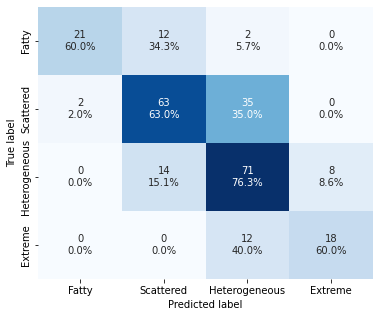

In [27]:
plot_cm(consensus_4, dl_4,4, 'DL_CM_4_TEST.tif')

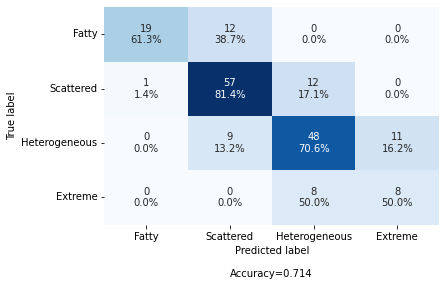

In [29]:
cm = np.array([[19,12,0,0],[1,57,12,0],[0,9,48,11],[0,0,8,8]])
#cm_display = ConfusionMatrixDisplay(cm).plot()

categories = ['Fatty', 'Scattered', 'Heterogeneous', 'Extreme']

make_confusion_matrix(cm,group_names=None,
                          categories=categories,
                          count=True,
                          percent=True,
                          cbar=False,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None)
plt.savefig('DL_CM_4_VAL.tif', dpi = 600, format = 'tif')

## Radiomics classification

In [6]:
path_to_train_radiomics = '../radiomics_pipeline/features/radiomic_features_train.csv'
path_to_val_radiomics = '../radiomics_pipeline/features/radiomic_features_validation.csv'
path_to_test_radiomics = '../radiomics_pipeline/features/radiomic_features_test.csv'

train_df_radiomics = pd.read_csv(path_to_train_radiomics)   
val_df_radiomics = pd.read_csv(path_to_val_radiomics)   
test_df_radiomics = pd.read_csv(path_to_test_radiomics)

test_df_radiomics = test_df_radiomics.drop([138,226,239])

train_feature_del = train_df_radiomics.columns.to_list()[0:17]

train_feature_df = train_df_radiomics.drop(columns=train_feature_del)
val_feature_df = val_df_radiomics.drop(columns=train_feature_del)
test_feature_df = test_df_radiomics.drop(columns=train_feature_del)

In [7]:
train_feature_df = drop_feat_with_low_var(train_feature_df, CENTERED_PERCENT=0.8, LOW_VAR_VAL=0.001)
feature_name = train_feature_df.columns.to_list()
#X = train_feature_df.values
X = train_feature_df
y = train_df_radiomics.Subject_Label
selecter = SelectPercentile(percentile = 25)
x_new = selecter.fit_transform(X, y)
#f, p = f_classif(X,y)
feature_names  = selecter.get_feature_names_out()

train_feature_df = train_df_radiomics[feature_names]
val_feature_df = val_df_radiomics[feature_names]
test_feature_df = test_df_radiomics[feature_names]

train_label_set = np.asarray(list(train_df_radiomics[train_df_radiomics.columns[2]]))
val_label_set = np.asarray(list(val_df_radiomics[val_df_radiomics.columns[2]]))
#######
#test_label_set = np.asarray(list(test_df_radiomics[test_df_radiomics.columns[2]]))
#######
x_train, x_val, y_train, y_val, x_test, y_test = train_feature_df.values, val_feature_df.values, \
train_label_set, val_label_set, test_feature_df.values, consensus_4
print('the size of the training subset is {}'.format(x_train.shape))
print('the size of the validation subset is {}'.format(x_val.shape))
print('the size of the test subset is {}'.format(x_test.shape))

x_train, x_val, x_test = feature_normalization(x_train, x_val, x_test=x_test)


Start drop low var features function
168 features dropped due to low variance
888 features in data-set after low var drop
the size of the training subset is (729, 222)
the size of the validation subset is (185, 222)
the size of the test subset is (258, 222)


In [8]:
clf_svm_2 = joblib.load('svm_2.pkl')
clf_rf_2 = joblib.load('rf_2.pkl')
clf_lr_2 = joblib.load('lr_2.pkl')

_, y_pred_rf_2,_, _,_,_ = test_clf(clf_rf_2, x_test, consensus_2)
_, y_pred_lr_2,_, _,_,_ = test_clf(clf_lr_2, x_test, consensus_2)
_, y_pred_svm_2,_, _,_,_ = test_clf(clf_svm_2, x_test, consensus_2)

clf_svm_4 = joblib.load('svm_4.pkl')
clf_rf_4 = joblib.load('rf_4.pkl')
clf_lr_4 = joblib.load('lr_4.pkl')

_, y_pred_rf_4,_, _,_,_ = test_clf(clf_rf_4, x_test, consensus_4)
_, y_pred_lr_4,_, _,_,_ = test_clf(clf_lr_4, x_test, consensus_4)
_, y_pred_svm_4,_, _,_,_ = test_clf(clf_svm_4, x_test, consensus_4)

              precision    recall  f1-score   support

           0       0.89      0.78      0.83       138
           1       0.78      0.89      0.83       120

    accuracy                           0.83       258
   macro avg       0.84      0.84      0.83       258
weighted avg       0.84      0.83      0.83       258

the accuracy score of the classifier is 0.8333333333333334
Confidence interval for the ACC score: [0.787 - 0.88]
the kappa score of the classifier is 0.6681026745647101
Confidence interval for the kappa score: [0.576 - 0.76]
AUC: 0.91243961352657
Confidence interval for the AUC score: [0.875 - 0.945]
              precision    recall  f1-score   support

           0       0.90      0.77      0.83       138
           1       0.77      0.90      0.83       120

    accuracy                           0.83       258
   macro avg       0.83      0.83      0.83       258
weighted avg       0.84      0.83      0.83       258

the accuracy score of the classifier is 0.82

/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confidence interval for the ACC score: [0.543 - 0.659]
the kappa score of the classifier is 0.5493821057834899
Confidence interval for the kappa score: [0.484 - 0.612]


In [32]:
c = Counter(y_pred_lr_4)
print(c)
for x, i in c.items():
    print(i)
    print(i/258)

Counter({2: 131, 1: 86, 0: 33, 3: 8})
131
0.5077519379844961
86
0.3333333333333333
8
0.031007751937984496
33
0.12790697674418605


In [33]:
c = Counter(y_pred_lr_2)
print(c)
for x, i in c.items():
    print(i)
    print(i/258)

Counter({1: 140, 0: 118})
140
0.5426356589147286
118
0.4573643410852713


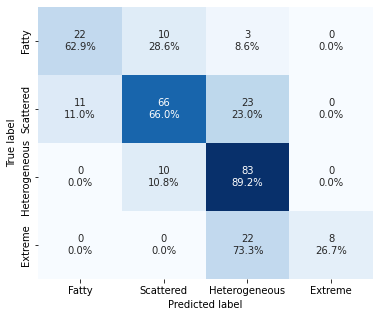

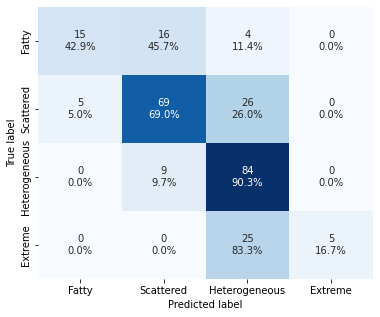

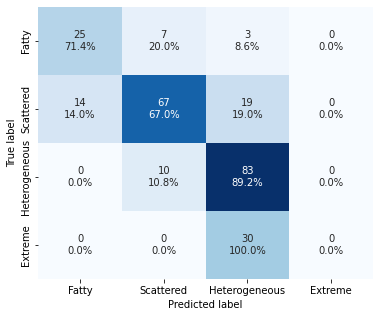

In [35]:
for clr,pred in zip(['LR','RF','SVM'],[y_pred_lr_4,y_pred_rf_4,y_pred_svm_4]):

    cm = confusion_matrix(consensus_4, pred)

    #categories = ['Fatty', 'Scattered', 'Heterogeneous', 'Dense']
    #categories = ['Nondense', 'Dense']

    make_confusion_matrix(cm,group_names=None,
                              categories=categories,
                              count=True,
                              percent=True,
                              cbar=False,
                              xyticks=True,
                              xyplotlabels=True,
                              sum_stats=False,
                              figsize=(6,5),
                              cmap='Blues',
                              title=None)
    file_name = 'RODOMIC_{}_CM_4_TEST.tif'.format(clr)
    plt.savefig(file_name, dpi = 600, format = 'tif')

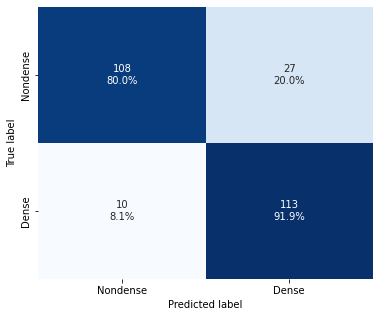

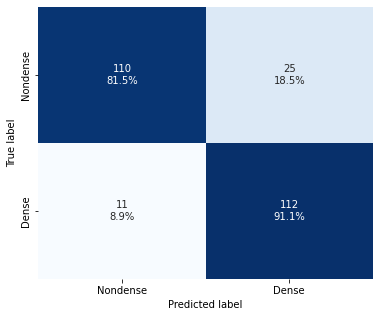

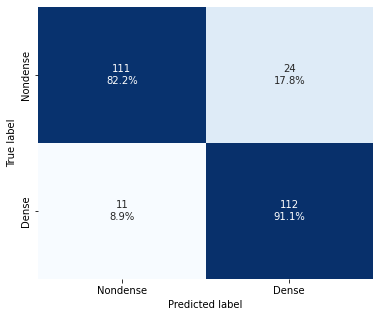

In [37]:
for clr,pred in zip(['LR','RF','SVM'],[y_pred_lr_2,y_pred_rf_2,y_pred_svm_2]):

    cm = confusion_matrix(consensus_2, pred)

    #categories = ['Fatty', 'Scattered', 'Heterogeneous', 'Dense']
    categories = ['Nondense', 'Dense']

    make_confusion_matrix(cm,group_names=None,
                              categories=categories,
                              count=True,
                              percent=True,
                              cbar=False,
                              xyticks=True,
                              xyplotlabels=True,
                              sum_stats=False,
                              figsize=(6,5),
                              cmap='Blues',
                              title=None)
    file_name = 'RODOMIC_{}_CM_2_TEST.tif'.format(clr)
    plt.savefig(file_name, dpi = 600, format = 'tif')

              precision    recall  f1-score   support

           0       0.91      0.82      0.86       135
           1       0.82      0.91      0.86       123

    accuracy                           0.86       258
   macro avg       0.87      0.87      0.86       258
weighted avg       0.87      0.86      0.86       258

the accuracy score of the classifier is 0.8643410852713178
Confidence interval for the ACC score: [0.822 - 0.907]
the kappa score of the classifier is 0.7293652220823593
Confidence interval for the kappa score: [0.644 - 0.808]
AUC: 0.9290575127973502
Confidence interval for the AUC score: [0.893 - 0.959]
              precision    recall  f1-score   support

           0       0.91      0.81      0.86       135
           1       0.82      0.91      0.86       123

    accuracy                           0.86       258
   macro avg       0.86      0.86      0.86       258
weighted avg       0.87      0.86      0.86       258

the accuracy score of the classifier is 

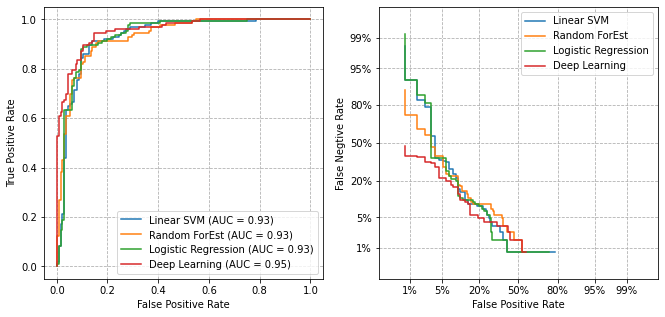

In [38]:
y_prob_dl = DL_pred_2.Probility.values


classifiers = {"Linear SVM":clf_svm_2,
               "Random ForEst":clf_rf_2,
               "Logistic Regression":clf_lr_2}

fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

for name, clf in classifiers.items():
    cm, y_pred, y_prob,  fpr, tpr, threshold = test_clf(clf, x_test, consensus_2)

    RocCurveDisplay.from_predictions(consensus_2, y_prob[:,1], pos_label = 1, ax=ax_roc, name=name)
    DetCurveDisplay.from_predictions(consensus_2, y_prob[:,1], pos_label = 1, ax=ax_det, name=name)

RocCurveDisplay.from_predictions(consensus_2, y_prob_dl, pos_label = 1, ax=ax_roc, name='Deep Learning')
DetCurveDisplay.from_predictions(consensus_2, y_prob_dl, pos_label = 1, ax=ax_det, name='Deep Learning')

#ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
#ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.set_xlabel('False Positive Rate')
ax_roc.set_ylabel('True Positive Rate')

ax_det.set_xlabel('False Positive Rate')
ax_det.set_ylabel('False Negtive Rate')

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
#plt.show()
plt.savefig('ALL_MODEL_ROC_2_TEST.tif', dpi = 600, format = 'tif')

## Extreme dense classification

In [39]:
_, y_pred_rf_4,y_prob_rf_4, _,_,_ = test_clf(clf_rf_4, x_val, y_val)
_, y_pred_lr_4,y_prob_lr_4, _,_,_ = test_clf(clf_lr_4, x_val, y_val)
_, y_pred_svm_4,y_prob_svm_4, _,_,_ = test_clf(clf_svm_4, x_val, y_val)
y_val_exd = np.array([0 if x < 3 else 1 for x in y_val])

              precision    recall  f1-score   support

           0       0.82      0.45      0.58        31
           1       0.66      0.77      0.71        70
           2       0.65      0.81      0.72        68
           3       1.00      0.06      0.12        16

    accuracy                           0.67       185
   macro avg       0.78      0.52      0.53       185
weighted avg       0.71      0.67      0.64       185

the accuracy score of the classifier is 0.6702702702702703
Confidence interval for the ACC score: [0.600 - 0.741]
the kappa score of the classifier is 0.5696288608138578
Confidence interval for the kappa score: [0.481 - 0.654]
              precision    recall  f1-score   support

           0       0.83      0.61      0.70        31
           1       0.70      0.76      0.73        70
           2       0.71      0.84      0.77        68
           3       0.83      0.31      0.45        16

    accuracy                           0.72       185
   macro avg

/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      0.14      0.24       169
           1       0.01      0.06      0.02        16
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0

    accuracy                           0.13       185
   macro avg       0.25      0.05      0.07       185
weighted avg       0.91      0.13      0.22       185

the accuracy score of the classifier is 0.12972972972972974
Confidence interval for the ACC score: [0.081 - 0.178]
the kappa score of the classifier is 0.016578070096405106
Confidence interval for the kappa score: [0.008 - 0.0282]
AUC: 0.14386094674556213
Confidence interval for the AUC score: [0.060 - 0.253]


/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      0.10      0.18       169
           1       0.01      0.06      0.02        16
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0

    accuracy                           0.10       185
   macro avg       0.25      0.04      0.05       185
weighted avg       0.91      0.10      0.17       185

the accuracy score of the classifier is 0.0972972972972973
Confidence interval for the ACC score: [0.054 - 0.141]
the kappa score of the classifier is 0.012153980205098502
Confidence interval for the kappa score: [0.005 - 0.0215]
AUC: 0.1786242603550296
Confidence interval for the AUC score: [0.088 - 0.291]
              precision    recall  f1-score   support

           0       1.00      0.14      0.24       169
           1       0.01      0.06      0.02        16
           2       0.00      0.00      0.00         0
           3       0.00      0.00      

/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confidence interval for the ACC score: [0.086 - 0.178]
the kappa score of the classifier is 0.01644104901040966
Confidence interval for the kappa score: [0.008 - 0.0279]
AUC: 0.16198224852071003
Confidence interval for the AUC score: [0.071 - 0.283]


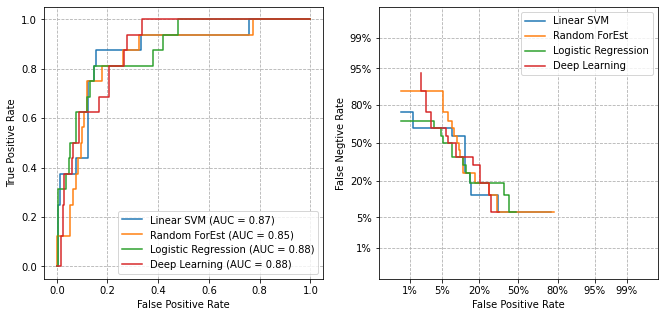

In [40]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset


y_prob_val_dl_exd = DL_pred_val_4.Probility_3


classifiers = {"Linear SVM":clf_svm_4,
               "Random ForEst":clf_rf_4,
               "Logistic Regression":clf_lr_4}

fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))


for name, clf in classifiers.items():
    cm, y_pred, y_prob,  fpr, tpr, threshold = test_clf(clf, x_val, y_val_exd)

    RocCurveDisplay.from_predictions(y_val_exd, y_prob[:,3], pos_label = 1, ax=ax_roc, name=name)
    DetCurveDisplay.from_predictions(y_val_exd, y_prob[:,3], pos_label = 1, ax=ax_det, name=name)

RocCurveDisplay.from_predictions(y_val_exd, y_prob_val_dl_exd, pos_label = 1, ax=ax_roc, name='Deep Learning')
DetCurveDisplay.from_predictions(y_val_exd, y_prob_val_dl_exd, pos_label = 1, ax=ax_det, name='Deep Learning')

#ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
#ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.set_xlabel('False Positive Rate')
ax_roc.set_ylabel('True Positive Rate')

ax_det.set_xlabel('False Positive Rate')
ax_det.set_ylabel('False Negtive Rate')

# ax_det.scatter(-0.5884757327666241, -1.5341205443525463, marker = 'x', c ='r')
# ax_det.scatter(-0.20159074, -1.53412054, marker = 'x', c ='g')
# ax_det.scatter(-0.43615828, -1.53412054, marker = 'x', c ='blue')
# ax_det.scatter(-0.4525295 , -1.53412054, marker = 'x', c ='y')

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()

plt.savefig('ALL_MODEL_ROC_EXD_VAL.tif', dpi = 600, format = 'tif')

In [281]:
########
# DL  th = 0.26174977
scipy.stats.norm.ppf([0.20710059171597633, 0.1875])

array([-0.81652281, -0.88714656])

In [282]:
######
# LR  th = 0.12954102968041467
scipy.stats.norm.ppf([0.14792899408284024, 0.1875])

array([-1.04535703, -0.88714656])

In [283]:
######
# svm th = 0.18033716687615003
scipy.stats.norm.ppf([0.14792899408284024, 0.1875])

array([-1.04535703, -0.88714656])

In [284]:
######
# rf  th = 0.13707952464202466
scipy.stats.norm.ppf([0.17751479289940827, 0.1875])

array([-0.92487759, -0.88714656])

In [285]:
#fpr, fnr, thresholds = det_curve(y_val_exd, y_prob_lr_4[:,3])
# fpr, fnr, thresholds = det_curve(y_val_exd, y_prob_val_dl_exd)
# for x,y,z in zip(fpr,fnr,thresholds):
#     print(x,y,z)

Confidence interval for the ACC score: [0.795 - 0.897]
Confidence interval for the AUC score: [0.789 - 0.95]
Confidence interval for the ACC score: [0.768 - 0.876]
Confidence interval for the AUC score: [0.744 - 0.932]
Confidence interval for the ACC score: [0.800 - 0.897]
Confidence interval for the AUC score: [0.763 - 0.947]


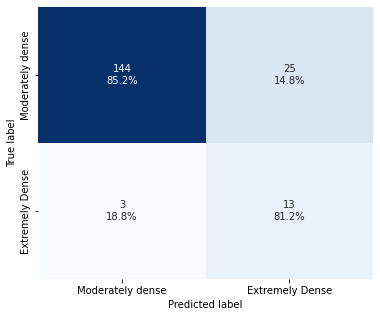

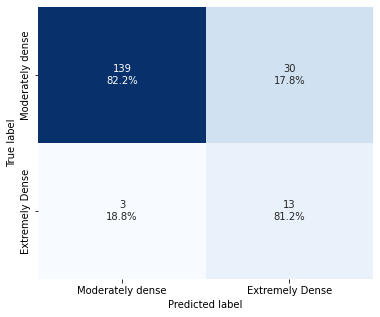

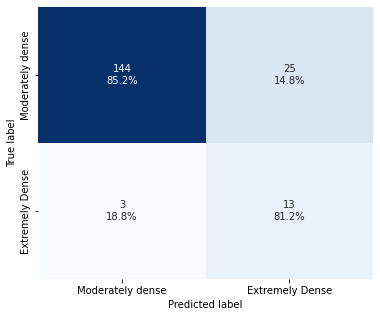

In [41]:
for clr,prob in zip(['LR','RF','SVM'],[y_prob_lr_4,y_prob_rf_4,y_prob_svm_4]):
    
    if clr == 'LR':
        th = 0.12954102968041467
    elif clr == 'RF':
        th = 0.13707952464202466
    elif clr == 'SVM':
        th = 0.18033716687615003
    
    pred = np.array([1 if x >= th else 0 for x in prob[:,3]])
    
    bootstraps(y_val_exd, pred,function='ACC')
    bootstraps(y_val_exd, np.array(prob[:,3]),function='AUC')
    
    #file_name = 'RADIOMIC_EXD_{}_CM_TEST.tif'.format(clr)
    #plot_cm(consensus_exd, pred, 'exd', file_name)
    file_name = 'RADIOMIC_EXD_{}_CM_VAL.tif'.format(clr)
    plot_cm(y_val_exd, pred, 'exd', file_name)
#    file_name = 'RADIOMIC_EXD_{}_CM_VAL.tif'.format(clr)
#    plt.savefig(file_name, dpi = 600, format = 'tif')

Confidence interval for the ACC score: [0.735 - 0.854]
Confidence interval for the AUC score: [0.816 - 0.939]


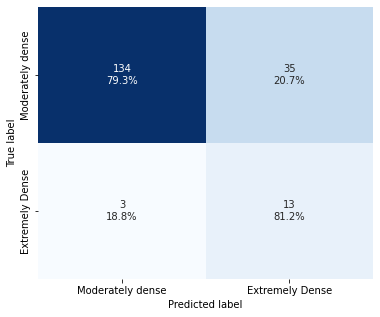

In [42]:
dl_exd_val_pred = np.array([1 if x >= 0.26174977 else 0 for x in y_prob_val_dl_exd])

file_name = 'DL_EXD_CM_VAL.tif'

bootstraps(y_val_exd, dl_exd_val_pred,function='ACC')
bootstraps(y_val_exd, y_prob_val_dl_exd,function='AUC')

plot_cm(y_val_exd, dl_exd_val_pred, 'exd', file_name)

### Test extreme dense vs non-extreme

In [9]:
_, y_pred_rf_4,y_prob_rf_4, _,_,_ = test_clf(clf_rf_4, x_test, consensus_exd, False)
_, y_pred_lr_4,y_prob_lr_4, _,_,_ = test_clf(clf_lr_4, x_test, consensus_exd, False)
_, y_pred_svm_4,y_prob_svm_4, _,_,_ = test_clf(clf_svm_4, x_test, consensus_exd, False)

/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      0.09      0.17       217
           1       0.00      0.00      0.00        41
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0

    accuracy                           0.08       258
   macro avg       0.25      0.02      0.04       258
weighted avg       0.84      0.08      0.14       258

the accuracy score of the classifier is 0.07751937984496124
Confidence interval for the ACC score: [0.047 - 0.112]
the kappa score of the classifier is 0.018040216482597904
Confidence interval for the kappa score: [0.010 - 0.0279]
AUC: 0.053276385298415205
Confidence interval for the AUC score: [0.029 - 0.0822]
              precision    recall  f1-score   support

           0       1.00      0.15      0.26       217
           1       0.00      0.00      0.00        41
           2       0.00      0.00      0.00         0
           3       0.00      0.00  

/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confidence interval for the ACC score: [0.089 - 0.171]
the kappa score of the classifier is 0.03071370198855894
Confidence interval for the kappa score: [0.019 - 0.0441]
AUC: 0.08935596268405081
Confidence interval for the AUC score: [0.056 - 0.127]
              precision    recall  f1-score   support

           0       1.00      0.18      0.30       217
           1       0.00      0.00      0.00        41
           2       0.00      0.00      0.00         0

    accuracy                           0.15       258
   macro avg       0.33      0.06      0.10       258
weighted avg       0.84      0.15      0.26       258

the accuracy score of the classifier is 0.1511627906976744


/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confidence interval for the ACC score: [0.109 - 0.194]
the kappa score of the classifier is 0.038093196112064076
Confidence interval for the kappa score: [0.025 - 0.0541]
AUC: 0.06417893672024277
Confidence interval for the AUC score: [0.037 - 0.0944]


0.7906976744186046
Confidence interval for the ACC score: [0.740 - 0.841]
0.9238304093567251
Confidence interval for the AUC score: [0.875 - 0.965]
Kappa score of LR for Extreme dense classification is:
kappa: 0.3990683229813665
Confidence interval for the kappa score: [0.281 - 0.517]
None
0.8178294573643411
Confidence interval for the ACC score: [0.767 - 0.864]
0.945906432748538
Confidence interval for the AUC score: [0.916 - 0.971]
Kappa score of RF for Extreme dense classification is:
kappa: 0.4724614983033151
Confidence interval for the kappa score: [0.356 - 0.584]
None
0.8372093023255814
Confidence interval for the ACC score: [0.791 - 0.88]
0.9649122807017544
Confidence interval for the AUC score: [0.941 - 0.985]
Kappa score of SVM for Extreme dense classification is:
kappa: 0.4983333333333334
Confidence interval for the kappa score: [0.376 - 0.616]
None


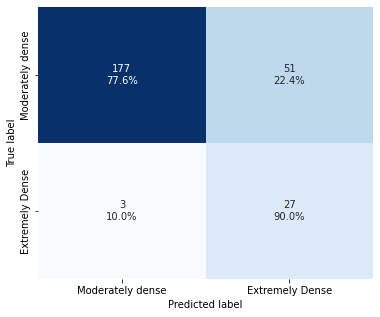

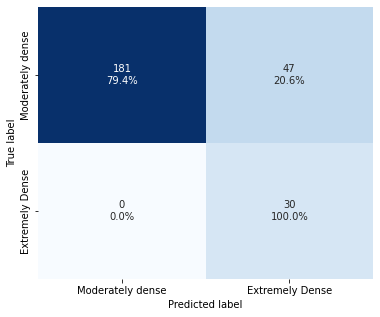

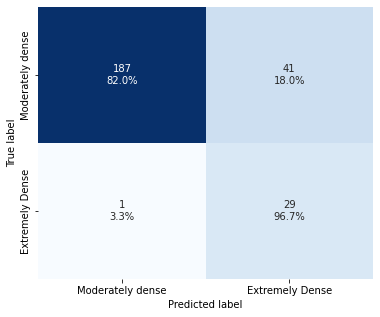

In [44]:
for clr,prob in zip(['LR','RF','SVM'],[y_prob_lr_4,y_prob_rf_4,y_prob_svm_4]):
    
    if clr == 'LR':
        th = 0.12954102968041467
    elif clr == 'RF':
        th = 0.13707952464202466
    elif clr == 'SVM':
        th = 0.18033716687615003
    
    pred = np.array([1 if x >= th else 0 for x in prob[:,3]])
    
    
    print(accuracy_score(consensus_exd, pred))
    bootstraps(consensus_exd, pred,function='ACC')
    
    print(roc_auc_score(consensus_exd, np.array(prob[:,3])))
    bootstraps(consensus_exd, np.array(prob[:,3]),function='AUC')
    
    print('Kappa score of {} for Extreme dense classification is:'.format(clr))
    print(kappa_score(np.array(pred),consensus_exd))
    
    file_name = 'RADIOMIC_EXD_{}_CM_TEST.tif'.format(clr)
    plot_cm(consensus_exd, pred, 'exd', file_name)

0.7945736434108527
Confidence interval for the ACC score: [0.744 - 0.841]
0.9587719298245614
Confidence interval for the AUC score: [0.930 - 0.982]
kappa: 0.43435095557210235
Confidence interval for the kappa score: [0.321 - 0.545]
None


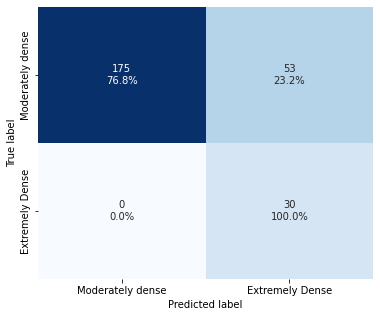

In [45]:
y_prob_test_dl_exd = DL_pred_4.Probility_3.values

dl_exd_pred = np.array([1 if x >= 0.26174977 else 0 for x in y_prob_test_dl_exd])

print(accuracy_score(consensus_exd, dl_exd_pred))
bootstraps(consensus_exd, dl_exd_pred,function='ACC')
    
print(roc_auc_score(consensus_exd, y_prob_test_dl_exd))
bootstraps(consensus_exd, y_prob_test_dl_exd,function='AUC')

print(kappa_score(dl_exd_pred,consensus_exd))

file_name = 'DL_EXD_CM_TEST.tif'

plot_cm(consensus_exd, dl_exd_pred, 'exd', file_name)

In [29]:
kappa_score(np.array(pred),consensus_exd)

kappa: 0.02723083368244672
Confidence interval for the kappa score: [0.017 - 0.0402]


/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      0.17      0.29       228
           1       0.00      0.00      0.00        30
           2       0.00      0.00      0.00         0

    accuracy                           0.15       258
   macro avg       0.33      0.06      0.10       258
weighted avg       0.88      0.15      0.26       258

the accuracy score of the classifier is 0.1511627906976744
Confidence interval for the ACC score: [0.109 - 0.194]
the kappa score of the classifier is 0.02723083368244672
Confidence interval for the kappa score: [0.017 - 0.0402]
AUC: 0.04839181286549708
Confidence interval for the AUC score: [0.025 - 0.0762]


/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      0.09      0.16       228
           1       0.00      0.00      0.00        30
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0

    accuracy                           0.08       258
   macro avg       0.25      0.02      0.04       258
weighted avg       0.88      0.08      0.14       258

the accuracy score of the classifier is 0.07751937984496124
Confidence interval for the ACC score: [0.047 - 0.112]
the kappa score of the classifier is 0.012860909266285026
Confidence interval for the kappa score: [0.007 - 0.0204]
AUC: 0.051023391812865505
Confidence interval for the AUC score: [0.026 - 0.0794]
              precision    recall  f1-score   support

           0       1.00      0.14      0.25       228
           1       0.00      0.00      0.00        30
           2       0.00      0.00      0.00         0
           3       0.00      0.00  

/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confidence interval for the ACC score: [0.089 - 0.171]
the kappa score of the classifier is 0.021947326416600244
Confidence interval for the kappa score: [0.013 - 0.0329]
AUC: 0.07426900584795322
Confidence interval for the AUC score: [0.042 - 0.113]


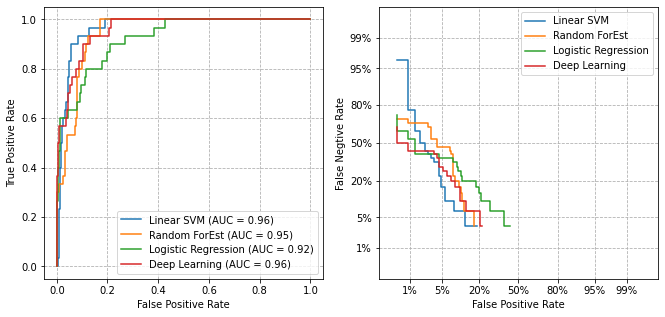

In [75]:
y_prob_dl_exd = DL_pred_4.Probility_3.values


classifiers = {"Linear SVM":clf_svm_4,
               "Random ForEst":clf_rf_4,
               "Logistic Regression":clf_lr_4}

fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

for name, clf in classifiers.items():
    cm, y_pred, y_prob,  fpr, tpr, threshold = test_clf(clf, x_test, consensus_exd)

    RocCurveDisplay.from_predictions(consensus_exd, y_prob[:,3], pos_label = 1, ax=ax_roc, name=name)
    DetCurveDisplay.from_predictions(consensus_exd, y_prob[:,3], pos_label = 1, ax=ax_det, name=name)

RocCurveDisplay.from_predictions(consensus_exd, y_prob_dl_exd, pos_label = 1, ax=ax_roc, name='Deep Learning')
DetCurveDisplay.from_predictions(consensus_exd, y_prob_dl_exd, pos_label = 1, ax=ax_det, name='Deep Learning')

#ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
#ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.set_xlabel('False Positive Rate')
ax_roc.set_ylabel('True Positive Rate')

ax_det.set_xlabel('False Positive Rate')
ax_det.set_ylabel('False Negtive Rate')

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
#plt.show()
plt.savefig('ALL_MODEL_ROC_EXD_TEST.tif', dpi = 600, format = 'tif')

In [168]:
###########
# two stage
##########
# clf_rf_1_2 = joblib.load('rf_1_2.pkl')
# clf_lr_1_2 = joblib.load('lr_1_2.pkl')
# clf_rf_3_4 = joblib.load('rf_3_4.pkl')
# clf_lr_3_4 = joblib.load('lr_3_4.pkl')

## kappa Rx_Rx, Rx_ML

### Four categories

#### RX_RX

In [34]:
kappa_score(l_1,l_2),
kappa_score(l_1,l_3),
kappa_score(l_1,l_4),
kappa_score(l_1,l_5),
kappa_score(l_2,l_3), 
kappa_score(l_2,l_4),
kappa_score(l_2,l_5),
kappa_score(l_3,l_4),
kappa_score(l_3,l_5),
kappa_score(l_4,l_5),

kappa: 0.6264598951127699
Confidence interval for the kappa score: [0.561 - 0.688]
kappa: 0.6314893149480855
Confidence interval for the kappa score: [0.576 - 0.685]
kappa: 0.5830789672137033
Confidence interval for the kappa score: [0.510 - 0.65]
kappa: 0.6525677909040828
Confidence interval for the kappa score: [0.589 - 0.713]
kappa: 0.6413377049180328
Confidence interval for the kappa score: [0.581 - 0.698]
kappa: 0.6289225941422594
Confidence interval for the kappa score: [0.558 - 0.694]
kappa: 0.7711064048995477
Confidence interval for the kappa score: [0.715 - 0.821]
kappa: 0.46984848899969867
Confidence interval for the kappa score: [0.406 - 0.529]
kappa: 0.7040681076672104
Confidence interval for the kappa score: [0.648 - 0.758]
kappa: 0.579959451987467
Confidence interval for the kappa score: [0.510 - 0.644]


(None,)

#### RX_Consensus

In [78]:
kappa_score(l_1,consensus_4),
kappa_score(l_2,consensus_4),
kappa_score(l_3,consensus_4),
kappa_score(l_4,consensus_4),
kappa_score(l_5,consensus_4)

kappa: 0.9135185867998525
Confidence interval for the kappa score: [0.875 - 0.948]
kappa: 0.7215369433822623
Confidence interval for the kappa score: [0.663 - 0.777]
kappa: 0.710646479211728
Confidence interval for the kappa score: [0.659 - 0.761]
kappa: 0.6824615384615385
Confidence interval for the kappa score: [0.611 - 0.745]
kappa: 0.7337382791767412
Confidence interval for the kappa score: [0.677 - 0.786]


#### Rx_DL

In [79]:
kappa_score(l_1, dl_4),
kappa_score(l_2, dl_4),
kappa_score(l_3, dl_4),
kappa_score(l_4, dl_4),
kappa_score(l_5, dl_4),

kappa: 0.5842835894893406
Confidence interval for the kappa score: [0.506 - 0.657]
kappa: 0.514788143766476
Confidence interval for the kappa score: [0.436 - 0.588]
kappa: 0.5484537787332562
Confidence interval for the kappa score: [0.484 - 0.609]
kappa: 0.5002094240837697
Confidence interval for the kappa score: [0.420 - 0.575]
kappa: 0.5673937790357813
Confidence interval for the kappa score: [0.492 - 0.635]


(None,)

#### Rx_RADIOMICS

In [80]:
kappa_score(l_1, y_pred_lr_4), 
kappa_score(l_2, y_pred_lr_4), 
kappa_score(l_3, y_pred_lr_4),
kappa_score(l_4, y_pred_lr_4),
kappa_score(l_5, y_pred_lr_4)

kappa: 0.5948877122512324
Confidence interval for the kappa score: [0.521 - 0.662]
kappa: 0.45652030807715094
Confidence interval for the kappa score: [0.381 - 0.528]
kappa: 0.5144604655024492
Confidence interval for the kappa score: [0.455 - 0.571]
kappa: 0.4883960047003525
Confidence interval for the kappa score: [0.406 - 0.564]
kappa: 0.5288709778981173
Confidence interval for the kappa score: [0.458 - 0.595]


In [10]:
pred_exd = {'LR':0,
            'RF':0,
            'SVM':0}

for clr,pred in zip(['LR','RF','SVM'],[y_pred_lr_4,y_pred_rf_4,y_pred_svm_4]):
    
    print('#'*20)
    print('4 categories predict by {}'.format(clr))
    
    #pred = np.array([1 if x >= th else 0 for x in prob[:,3]])
    
    for rx, label in zip(['R_1','R_2','R_3','R_4','R_5','Consensus'], [l_1,l_2,l_3,l_4,l_5,consensus_4]):
        print("Kappa score with {} is: ".format(rx))
        print(kappa_score(label, pred))

####################
4 categories predict by LR
Kappa score with R_1 is: 
kappa: 0.5948877122512324
Confidence interval for the kappa score: [0.521 - 0.662]
None
Kappa score with R_2 is: 
kappa: 0.45652030807715094
Confidence interval for the kappa score: [0.381 - 0.528]
None
Kappa score with R_3 is: 
kappa: 0.5144604655024492
Confidence interval for the kappa score: [0.455 - 0.571]
None
Kappa score with R_4 is: 
kappa: 0.4883960047003525
Confidence interval for the kappa score: [0.406 - 0.564]
None
Kappa score with R_5 is: 
kappa: 0.5288709778981173
Confidence interval for the kappa score: [0.458 - 0.595]
None
Kappa score with Consensus is: 
kappa: 0.5606065568401402
Confidence interval for the kappa score: [0.491 - 0.628]
None
####################
4 categories predict by RF
Kappa score with R_1 is: 
kappa: 0.5438685110351259
Confidence interval for the kappa score: [0.470 - 0.613]
None
Kappa score with R_2 is: 
kappa: 0.4073370410031435
Confidence interval for the kappa score: [0.331

#### DL_consensus

In [81]:
kappa_score(dl_4, consensus_4),
kappa_score(y_pred_lr_4, consensus_4)

kappa: 0.624196356817573
Confidence interval for the kappa score: [0.549 - 0.693]
kappa: 0.6349896480331263
Confidence interval for the kappa score: [0.566 - 0.702]


#### CAD vs consensus

In [82]:
cad = []
for x in (l_1,l_2,l_3,l_4,l_5):
    aided = majority_vote(x,dl_4,y_pred_lr_4,y_pred_svm_4)
    cad.append(aided)
    print(kappa_score(aided, consensus_4), kappa_score(x, consensus_4))

kappa: 0.7634010450911859
Confidence interval for the kappa score: [0.698 - 0.822]
kappa: 0.9135185867998525
Confidence interval for the kappa score: [0.875 - 0.948]
None None
kappa: 0.7277842907385698
Confidence interval for the kappa score: [0.663 - 0.788]
kappa: 0.7215369433822623
Confidence interval for the kappa score: [0.663 - 0.777]
None None
kappa: 0.7379486021990778
Confidence interval for the kappa score: [0.676 - 0.796]
kappa: 0.710646479211728
Confidence interval for the kappa score: [0.659 - 0.761]
None None
kappa: 0.7149121268460379
Confidence interval for the kappa score: [0.647 - 0.777]
kappa: 0.6824615384615385
Confidence interval for the kappa score: [0.611 - 0.745]
None None
kappa: 0.7312766590616011
Confidence interval for the kappa score: [0.669 - 0.79]
kappa: 0.7337382791767412
Confidence interval for the kappa score: [0.677 - 0.786]
None None


#### Aided consensus vs consensus

In [83]:
consensus_a = majority_vote(cad[0],cad[1],cad[2],cad[3],cad[4])
kappa_score(consensus_a,consensus_4)

kappa: 0.7852505410354587
Confidence interval for the kappa score: [0.725 - 0.84]


In [84]:
kappa_score(cad[0], cad[1]),
kappa_score(cad[0], cad[2]),
kappa_score(cad[0], cad[3]),
kappa_score(cad[0], cad[4]),
kappa_score(cad[1], cad[2]),
kappa_score(cad[1], cad[3]),
kappa_score(cad[1], cad[4]),
kappa_score(cad[2], cad[3]),
kappa_score(cad[2], cad[4]),
kappa_score(cad[3], cad[4])

kappa: 0.8386728951337036
Confidence interval for the kappa score: [0.786 - 0.888]
kappa: 0.8460782593437445
Confidence interval for the kappa score: [0.794 - 0.893]
kappa: 0.82987471393662
Confidence interval for the kappa score: [0.773 - 0.882]
kappa: 0.8503859954332935
Confidence interval for the kappa score: [0.798 - 0.898]
kappa: 0.8687735241260045
Confidence interval for the kappa score: [0.822 - 0.911]
kappa: 0.8656799672752966
Confidence interval for the kappa score: [0.816 - 0.911]
kappa: 0.9099004714510215
Confidence interval for the kappa score: [0.867 - 0.945]
kappa: 0.8079880922847928
Confidence interval for the kappa score: [0.753 - 0.858]
kappa: 0.9049532804179644
Confidence interval for the kappa score: [0.865 - 0.942]
kappa: 0.8488410414149181
Confidence interval for the kappa score: [0.795 - 0.895]


In [85]:
kappa_score(cad[0], consensus_a), 
kappa_score(cad[1], consensus_a), 
kappa_score(cad[2], consensus_a), 
kappa_score(cad[3], consensus_a),
kappa_score(cad[4], consensus_a),

kappa: 0.901250318958918
Confidence interval for the kappa score: [0.856 - 0.941]
kappa: 0.9410979593270346
Confidence interval for the kappa score: [0.907 - 0.97]
kappa: 0.9174941932877773
Confidence interval for the kappa score: [0.881 - 0.95]
kappa: 0.8810402065658429
Confidence interval for the kappa score: [0.833 - 0.923]
kappa: 0.9419100072742388
Confidence interval for the kappa score: [0.908 - 0.97]


(None,)

In [86]:
kappa_score(cad[0], l_1),
kappa_score(cad[1], l_2),
kappa_score(cad[2], l_3),
kappa_score(cad[3], l_4),
kappa_score(cad[4], l_5),

kappa: 0.7871209065238917
Confidence interval for the kappa score: [0.725 - 0.842]
kappa: 0.6809699694877147
Confidence interval for the kappa score: [0.614 - 0.743]
kappa: 0.6989780865273717
Confidence interval for the kappa score: [0.644 - 0.75]
kappa: 0.6888471993567901
Confidence interval for the kappa score: [0.610 - 0.758]
kappa: 0.7373985962993346
Confidence interval for the kappa score: [0.677 - 0.792]


(None,)

## Binary classification

In [36]:
kappa_score(l_1_b,l_2_b),
kappa_score(l_1_b,l_3_b),
kappa_score(l_1_b,l_4_b),
kappa_score(l_1_b,l_5_b),
kappa_score(l_2_b,l_3_b),
kappa_score(l_2_b,l_4_b),
kappa_score(l_2_b,l_5_b),
kappa_score(l_3_b,l_4_b),
kappa_score(l_3_b,l_5_b),
kappa_score(l_4_b,l_5_b),

kappa: 0.7283883775491788
Confidence interval for the kappa score: [0.643 - 0.806]
kappa: 0.8449891852919971
Confidence interval for the kappa score: [0.776 - 0.907]
kappa: 0.6483736143921497
Confidence interval for the kappa score: [0.558 - 0.734]
kappa: 0.7986311239193083
Confidence interval for the kappa score: [0.721 - 0.868]
kappa: 0.7132816723734006
Confidence interval for the kappa score: [0.623 - 0.798]
kappa: 0.6534163766257557
Confidence interval for the kappa score: [0.563 - 0.74]
kappa: 0.7910743206766241
Confidence interval for the kappa score: [0.714 - 0.861]
kappa: 0.6056937368894217
Confidence interval for the kappa score: [0.512 - 0.693]
kappa: 0.8138975715316181
Confidence interval for the kappa score: [0.737 - 0.883]
kappa: 0.579206452760809
Confidence interval for the kappa score: [0.486 - 0.667]


(None,)

In [37]:
kappa_score(l_1_b, consensus_2),
kappa_score(l_2_b, consensus_2),
kappa_score(l_3_b, consensus_2),
kappa_score(l_4_b, consensus_2),
kappa_score(l_5_b, consensus_2)

kappa: 0.9611983396498827
Confidence interval for the kappa score: [0.922 - 0.992]
kappa: 0.7669376693766938
Confidence interval for the kappa score: [0.684 - 0.837]
kappa: 0.8837628401513786
Confidence interval for the kappa score: [0.822 - 0.938]
kappa: 0.6849239787506869
Confidence interval for the kappa score: [0.596 - 0.764]
kappa: 0.822026273168976
Confidence interval for the kappa score: [0.752 - 0.891]


In [90]:
kappa_score(l_1_b, dl_2),
kappa_score(l_2_b, dl_2),
kappa_score(l_3_b, dl_2),
kappa_score(l_4_b, dl_2),
kappa_score(l_5_b, dl_2),

kappa: 0.7750315713512539
Confidence interval for the kappa score: [0.697 - 0.852]
kappa: 0.642895829572125
Confidence interval for the kappa score: [0.543 - 0.732]
kappa: 0.821748272754581
Confidence interval for the kappa score: [0.751 - 0.89]
kappa: 0.5769207409656848
Confidence interval for the kappa score: [0.479 - 0.669]
kappa: 0.7444931276634055
Confidence interval for the kappa score: [0.659 - 0.822]


(None,)

In [91]:
kappa_score(l_1_b, y_pred_lr_2), 
kappa_score(l_2_b, y_pred_lr_2), 
kappa_score(l_3_b, y_pred_lr_2),
kappa_score(l_4_b, y_pred_lr_2),
kappa_score(l_5_b, y_pred_lr_2)

kappa: 0.6905361640878014
Confidence interval for the kappa score: [0.598 - 0.774]
kappa: 0.5135571915963368
Confidence interval for the kappa score: [0.406 - 0.614]
kappa: 0.736259771497294
Confidence interval for the kappa score: [0.650 - 0.814]
kappa: 0.5103649635036496
Confidence interval for the kappa score: [0.414 - 0.603]
kappa: 0.6422283853852647
Confidence interval for the kappa score: [0.544 - 0.729]


In [38]:
pred_exd = {'LR':0,
            'RF':0,
            'SVM':0}
for clr,pred in zip(['LR','RF','SVM'],[y_pred_lr_2,y_pred_rf_2,y_pred_svm_2]):
    
    print('#'*20)
    print('Binary categories predict by {}'.format(clr))
    
    #pred = np.array([1 if x >= th else 0 for x in prob[:,3]])
    
    for rx, label in zip(['R_1','R_2','R_3','R_4','R_5','Consensus'], [l_1_b,l_2_b,l_3_b,l_4_b,l_5_b,consensus_2]):
        print("Kappa score with {} is: ".format(rx))
        print(kappa_score(label, pred))

####################
Binary categories predict by LR
Kappa score with R_1 is: 
kappa: 0.6905361640878014
Confidence interval for the kappa score: [0.598 - 0.774]
None
Kappa score with R_2 is: 
kappa: 0.5135571915963368
Confidence interval for the kappa score: [0.406 - 0.614]
None
Kappa score with R_3 is: 
kappa: 0.736259771497294
Confidence interval for the kappa score: [0.650 - 0.814]
None
Kappa score with R_4 is: 
kappa: 0.5103649635036496
Confidence interval for the kappa score: [0.414 - 0.603]
None
Kappa score with R_5 is: 
kappa: 0.6422283853852647
Confidence interval for the kappa score: [0.544 - 0.729]
None
Kappa score with Consensus is: 
kappa: 0.7143113664930867
Confidence interval for the kappa score: [0.627 - 0.792]
None
####################
Binary categories predict by RF
Kappa score with R_1 is: 
kappa: 0.6826282628262825
Confidence interval for the kappa score: [0.593 - 0.767]
None
Kappa score with R_2 is: 
kappa: 0.5207621786805681
Confidence interval for the kappa score

In [92]:
kappa_score(dl_2, consensus_2), 
kappa_score(y_pred_lr_2, consensus_2)

kappa: 0.7826322440873804
Confidence interval for the kappa score: [0.703 - 0.857]
kappa: 0.7143113664930867
Confidence interval for the kappa score: [0.627 - 0.792]


In [93]:
cad = []
for x in (l_1_b,l_2_b,l_3_b, l_4_b, l_5_b):
    aided = majority_vote(x,dl_2, y_pred_lr_2, y_pred_svm_2)
    cad.append(aided)
    print(kappa_score(aided, consensus_2), kappa_score(x, consensus_2))

kappa: 0.8837628401513786
Confidence interval for the kappa score: [0.822 - 0.938]
kappa: 0.9611983396498827
Confidence interval for the kappa score: [0.922 - 0.992]
None None
kappa: 0.8370330265295073
Confidence interval for the kappa score: [0.767 - 0.899]
kappa: 0.7669376693766938
Confidence interval for the kappa score: [0.684 - 0.837]
None None
kappa: 0.8604651162790697
Confidence interval for the kappa score: [0.796 - 0.922]
kappa: 0.8837628401513786
Confidence interval for the kappa score: [0.822 - 0.938]
None None
kappa: 0.8211249773919335
Confidence interval for the kappa score: [0.745 - 0.89]
kappa: 0.6849239787506869
Confidence interval for the kappa score: [0.596 - 0.764]
None None
kappa: 0.875879487642071
Confidence interval for the kappa score: [0.814 - 0.93]
kappa: 0.822026273168976
Confidence interval for the kappa score: [0.752 - 0.891]
None None


In [94]:
kappa_score(cad[0], cad[1]),
kappa_score(cad[0], cad[2]), 
kappa_score(cad[0], cad[3]),
kappa_score(cad[0], cad[4]),
kappa_score(cad[1], cad[2]),
kappa_score(cad[1], cad[3]),
kappa_score(cad[1], cad[4]),
kappa_score(cad[2], cad[3]),
kappa_score(cad[2], cad[4]),
kappa_score(cad[3], cad[4]),

kappa: 0.9379956741167988
Confidence interval for the kappa score: [0.892 - 0.977]
kappa: 0.9612403100775194
Confidence interval for the kappa score: [0.922 - 0.992]
kappa: 0.9225225225225225
Confidence interval for the kappa score: [0.869 - 0.961]
kappa: 0.9767469807126119
Confidence interval for the kappa score: [0.946 - 1.0]
kappa: 0.9457364341085271
Confidence interval for the kappa score: [0.906 - 0.984]
kappa: 0.9223546406644998
Confidence interval for the kappa score: [0.868 - 0.968]
kappa: 0.9612263300270514
Confidence interval for the kappa score: [0.922 - 0.992]
kappa: 0.8992248062015504
Confidence interval for the kappa score: [0.844 - 0.946]
kappa: 0.9844961240310077
Confidence interval for the kappa score: [0.961 - 1.0]
kappa: 0.914636347229742
Confidence interval for the kappa score: [0.860 - 0.961]


(None,)

In [95]:
kappa_score(cad[0], l_1_b), 
kappa_score(cad[1], l_2_b), 
kappa_score(cad[2], l_3_b), 
kappa_score(cad[3], l_4_b),
kappa_score(cad[4], l_5_b),

kappa: 0.8759913482335977
Confidence interval for the kappa score: [0.813 - 0.93]
kappa: 0.7128677134091319
Confidence interval for the kappa score: [0.625 - 0.791]
kappa: 0.9147286821705426
Confidence interval for the kappa score: [0.860 - 0.961]
kappa: 0.6744228993536472
Confidence interval for the kappa score: [0.584 - 0.76]
kappa: 0.8373070686445259
Confidence interval for the kappa score: [0.767 - 0.899]


(None,)

In [96]:
consensus_a = majority_vote(cad[0], cad[1], cad[2], cad[3])

In [97]:
kappa_score(consensus_a,consensus_2)

kappa: 0.8914728682170543
Confidence interval for the kappa score: [0.835 - 0.945]


## Extreme dense vs Non-extreme dense

### Rx_exd vs Rx_exd

In [39]:
kappa_score(l_1_exd,l_2_exd),
kappa_score(l_1_exd,l_3_exd),
kappa_score(l_1_exd,l_4_exd),
kappa_score(l_1_exd,l_5_exd),
kappa_score(l_2_exd,l_3_exd), 
kappa_score(l_2_exd,l_4_exd),
kappa_score(l_2_exd,l_5_exd),
kappa_score(l_3_exd,l_4_exd),
kappa_score(l_3_exd,l_5_exd),
kappa_score(l_4_exd,l_5_exd),

kappa: 0.5283683141503046
Confidence interval for the kappa score: [0.367 - 0.675]
kappa: 0.4028309445384137
Confidence interval for the kappa score: [0.288 - 0.523]
kappa: 0.3110446485793633
Confidence interval for the kappa score: [0.104 - 0.507]
kappa: 0.4733306993283287
Confidence interval for the kappa score: [0.306 - 0.624]
kappa: 0.6026804295346708
Confidence interval for the kappa score: [0.492 - 0.711]
kappa: 0.3556041211364347
Confidence interval for the kappa score: [0.189 - 0.519]
kappa: 0.7100472016183412
Confidence interval for the kappa score: [0.581 - 0.824]
kappa: 0.21348841572085164
Confidence interval for the kappa score: [0.113 - 0.325]
kappa: 0.6273830155979202
Confidence interval for the kappa score: [0.520 - 0.732]
kappa: 0.4168173598553345
Confidence interval for the kappa score: [0.249 - 0.568]


(None,)

### Rx_exd vs consensus_exd

In [99]:
kappa_score(l_1_exd,consensus_exd),
kappa_score(l_2_exd,consensus_exd),
kappa_score(l_3_exd,consensus_exd),
kappa_score(l_4_exd,consensus_exd),
kappa_score(l_5_exd,consensus_exd),

kappa: 0.8983451536643026
Confidence interval for the kappa score: [0.794 - 0.977]
kappa: 0.6375478927203064
Confidence interval for the kappa score: [0.491 - 0.766]
kappa: 0.4724614983033151
Confidence interval for the kappa score: [0.354 - 0.589]
kappa: 0.5091324200913242
Confidence interval for the kappa score: [0.311 - 0.68]
kappa: 0.5822122571001496
Confidence interval for the kappa score: [0.428 - 0.717]


(None,)

In [100]:
kappa_score(l_1_exd, np.array(dl_exd_pred)),
kappa_score(l_2_exd, np.array(dl_exd_pred)),
kappa_score(l_3_exd, np.array(dl_exd_pred)),
kappa_score(l_4_exd, np.array(dl_exd_pred)),
kappa_score(l_5_exd, np.array(dl_exd_pred)),

kappa: 0.3689803491608332
Confidence interval for the kappa score: [0.261 - 0.479]
kappa: 0.5373396030923727
Confidence interval for the kappa score: [0.423 - 0.643]
kappa: 0.7465085269141694
Confidence interval for the kappa score: [0.651 - 0.83]
kappa: 0.1931107391419259
Confidence interval for the kappa score: [0.101 - 0.292]
kappa: 0.5407073344410159
Confidence interval for the kappa score: [0.429 - 0.647]


(None,)

In [11]:
pred_exd = {'LR':0,
            'RF':0,
            'SVM':0}

for clr,prob in zip(['LR','RF','SVM'],[y_prob_lr_4,y_prob_rf_4,y_prob_svm_4]):
    
    print('#'*20)
    print('Extreme dense selection by {}'.format(clr))
    
    if clr == 'LR':
        th = 0.12954102968041467
    elif clr == 'RF':
        th = 0.13707952464202466
    elif clr == 'SVM':
        th = 0.18033716687615003
    
    pred = np.array([1 if x >= th else 0 for x in prob[:,3]])
    
    pred_exd[clr] = pred
    
    for rx, label in zip(['R_1','R_2','R_3','R_4','R_5','Consensus'], [l_1_exd,l_2_exd,l_3_exd,l_4_exd,l_5_exd,consensus_exd]):
        print("Kappa score with {} is: ".format(rx))
        print(kappa_score(label, pred))

####################
Extreme dense selection by LR
Kappa score with R_1 is: 
kappa: 0.35141571844403274
Confidence interval for the kappa score: [0.236 - 0.47]
None
Kappa score with R_2 is: 
kappa: 0.4243926623698563
Confidence interval for the kappa score: [0.297 - 0.544]
None
Kappa score with R_3 is: 
kappa: 0.6403602830795625
Confidence interval for the kappa score: [0.529 - 0.74]
None
Kappa score with R_4 is: 
kappa: 0.16202672605790636
Confidence interval for the kappa score: [0.065 - 0.265]
None
Kappa score with R_5 is: 
kappa: 0.42920353982300885
Confidence interval for the kappa score: [0.306 - 0.549]
None
Kappa score with Consensus is: 
kappa: 0.4586521846457665
Confidence interval for the kappa score: [0.336 - 0.575]
None
####################
Extreme dense selection by RF
Kappa score with R_1 is: 
kappa: 0.4028309445384137
Confidence interval for the kappa score: [0.287 - 0.519]
None
Kappa score with R_2 is: 
kappa: 0.4738200283026721
Confidence interval for the kappa score: 

In [54]:
c = Counter(pred_exd['SVM'])
print(c)
for x, i in c.items():
    print(i)
    print(i/258)

Counter({0: 188, 1: 70})
70
0.2713178294573643
188
0.7286821705426356


In [102]:
kappa_score(np.array(dl_exd_pred), consensus_exd)

kappa: 0.43435095557210235
Confidence interval for the kappa score: [0.321 - 0.545]


In [103]:
cad = []
for x in (l_1_exd,l_2_exd,l_3_exd,l_4_exd,l_5_exd):
    #aided = majority_vote(x,np.array(dl_exd_pred), pred_exd['SVM'])
    aided = majority_vote(x,pred_exd['RF'], pred_exd['SVM'])
    cad.append(aided)
    print(kappa_score(aided, consensus_exd), kappa_score(x, consensus_exd))

kappa: 0.6338694418164617
Confidence interval for the kappa score: [0.507 - 0.751]
kappa: 0.8983451536643026
Confidence interval for the kappa score: [0.794 - 0.977]
None None
kappa: 0.5881989496447327
Confidence interval for the kappa score: [0.458 - 0.707]
kappa: 0.6375478927203064
Confidence interval for the kappa score: [0.491 - 0.766]
None None
kappa: 0.5376344086021505
Confidence interval for the kappa score: [0.413 - 0.654]
kappa: 0.4724614983033151
Confidence interval for the kappa score: [0.354 - 0.589]
None None
kappa: 0.6163161249203315
Confidence interval for the kappa score: [0.485 - 0.737]
kappa: 0.5091324200913242
Confidence interval for the kappa score: [0.311 - 0.68]
None None
kappa: 0.5973782771535581
Confidence interval for the kappa score: [0.466 - 0.716]
kappa: 0.5822122571001496
Confidence interval for the kappa score: [0.428 - 0.717]
None None


In [105]:
consensus_exd_a = majority_vote(cad[0],cad[1],cad[2],cad[3])
kappa_score(consensus_exd_a,consensus_exd)

kappa: 0.6338694418164617
Confidence interval for the kappa score: [0.507 - 0.751]


In [106]:
kappa_score(cad[0], cad[1]), 
kappa_score(cad[0], cad[2]), 
kappa_score(cad[0], cad[3]), 
kappa_score(cad[0], cad[4]), 
kappa_score(cad[1], cad[2]),
kappa_score(cad[1], cad[3]),
kappa_score(cad[1], cad[4]),
kappa_score(cad[2], cad[3]),
kappa_score(cad[2], cad[4]),
kappa_score(cad[3], cad[4]),

kappa: 0.9555210757693302
Confidence interval for the kappa score: [0.908 - 0.99]
kappa: 0.8841538084741611
Confidence interval for the kappa score: [0.813 - 0.946]
kappa: 0.98866930171278
Confidence interval for the kappa score: [0.963 - 1.0]
kappa: 0.9664324746291959
Confidence interval for the kappa score: [0.923 - 1.0]
kappa: 0.9061514833077359
Confidence interval for the kappa score: [0.844 - 0.96]
kappa: 0.9664382967652415
Confidence interval for the kappa score: [0.923 - 1.0]
kappa: 0.9668408876702939
Confidence interval for the kappa score: [0.924 - 1.0]
kappa: 0.8729898260584181
Confidence interval for the kappa score: [0.798 - 0.938]
kappa: 0.8952071486596264
Confidence interval for the kappa score: [0.829 - 0.956]
kappa: 0.9774829813230931
Confidence interval for the kappa score: [0.940 - 1.0]


(None,)

In [107]:
kappa_score(cad[0], consensus_exd_a), 
kappa_score(cad[1], consensus_exd_a), 
kappa_score(cad[2], consensus_exd_a), 
kappa_score(cad[3], consensus_exd_a),
kappa_score(cad[4], consensus_exd_a)

kappa: 1.0
Confidence interval for the kappa score: [1.000 - 1.0]
kappa: 0.9555210757693302
Confidence interval for the kappa score: [0.908 - 0.99]
kappa: 0.8841538084741611
Confidence interval for the kappa score: [0.813 - 0.946]
kappa: 0.98866930171278
Confidence interval for the kappa score: [0.963 - 1.0]
kappa: 0.9664324746291959
Confidence interval for the kappa score: [0.923 - 1.0]


In [109]:
kappa_score(cad[0], l_1_exd), 
kappa_score(cad[1], l_2_exd), 
kappa_score(cad[2], l_3_exd), 
kappa_score(cad[3], l_4_exd),
kappa_score(cad[4], l_5_exd),

kappa: 0.5490003277613897
Confidence interval for the kappa score: [0.413 - 0.676]
kappa: 0.6902314859283449
Confidence interval for the kappa score: [0.570 - 0.797]
kappa: 0.7988714826638948
Confidence interval for the kappa score: [0.711 - 0.875]
kappa: 0.28037836526800874
Confidence interval for the kappa score: [0.148 - 0.418]
kappa: 0.6548165137614679
Confidence interval for the kappa score: [0.533 - 0.763]


(None,)

In [13]:
from pycirclize import Circos
import numpy as np

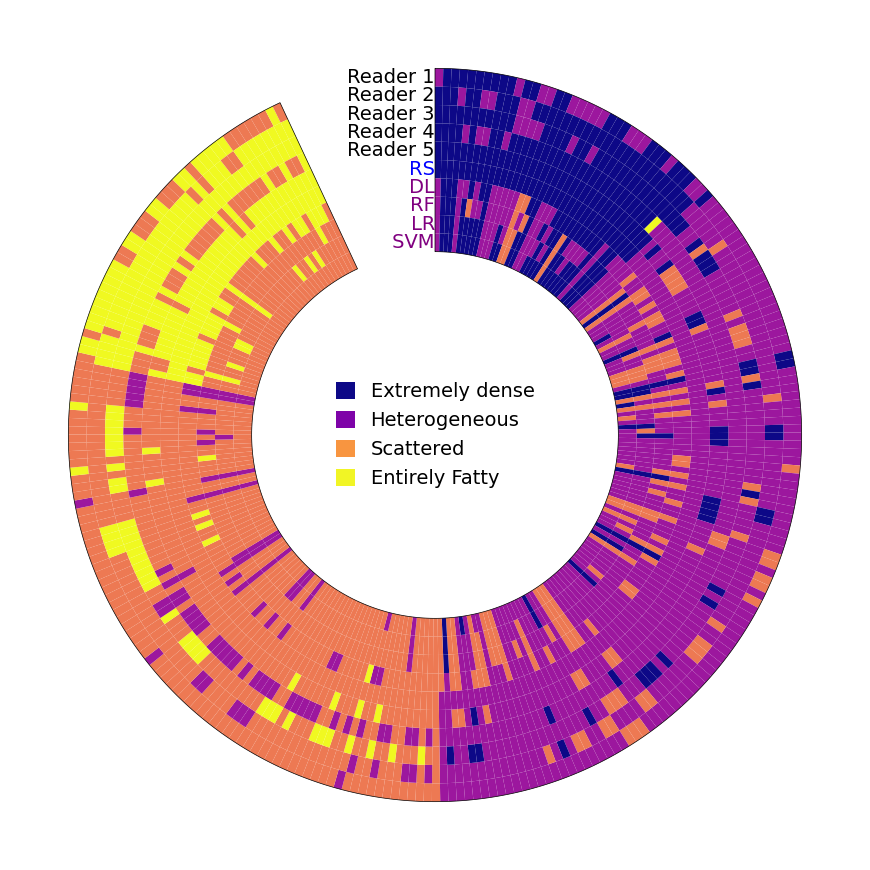

In [18]:
sectors = {"A": 258}
circos = Circos(sectors, end=340, space=5)
vmin2, vmax2 = 0, 3
for sector in circos.sectors:
    # Plot heatmap 
#     track1 = sector.add_track((80, 100))
#     track1.axis()
#     track1.xticks_by_interval(1)
#     data = np.random.randint(vmin1, vmax1 + 1, (4, int(sector.size)))
#     track1.heatmap(data, vmin=vmin1, vmax=vmax1, show_value=True)
    # Plot heatmap with labels
    track2 = sector.add_track((50, 100))
    track2.axis()
#     x = np.linspace(1, int(track2.size), int(track2.size)) - 0.5
#     xlabels = [str(int(v + 1)) for v in x]
#     track2.xticks(x, xlabels, outer=False)
#     track2.yticks([0.5, 1.5, 2.5, 3.5, 4.5], list("ABCDE"), vmin=0, vmax=5)
    #data = np.random.randint(vmin2, vmax2 + 1, (5, int(sector.size)))
    data = np.vstack((l_1,l_2,l_3,l_4,l_5, consensus_4, dl_4,  y_pred_rf_4, y_pred_lr_4, y_pred_svm_4))
    data = data[::, data[5,].argsort()]
    heatmap_4 = track2.heatmap(data, vmin=vmin2, vmax=vmax2, cmap="plasma")#rect_kws=dict(ec="white", lw=1))

#circos.colorbar(bounds=(0.35, 0.55, 0.3, 0.01), vmin=vmin1, vmax=vmax1, orientation="horizontal")
# circos.colorbar(bounds=(0.35, 0.45, 0.3, 0.01), vmin=vmin2, vmax=vmax2, orientation="horizontal", cmap="viridis")

    text_common_kws = dict(ha="right", va="center", size=14)
    circos.text(" Reader 1", r=97.5,  **text_common_kws)
    circos.text(" Reader 2", r=92.5,  **text_common_kws)
    circos.text(" Reader 3", r=87.5,  **text_common_kws)
    circos.text(" Reader 4", r=82.5,  **text_common_kws)
    circos.text(" Reader 5", r=77.5,  **text_common_kws)
    circos.text(" RS", r=72.5, color="blue", **text_common_kws)
    circos.text(" DL", r=67.5, color="purple", **text_common_kws)
    circos.text(" RF", r=62.5, color="purple", **text_common_kws)
    circos.text(" LR", r=57.5, color="purple", **text_common_kws)
    circos.text(" SVM", r=52.5, color="purple", **text_common_kws)

fig = circos.plotfig()


cmap = plt.cm.get_cmap("plasma")

from matplotlib.patches import Patch

_ = circos.ax.legend(
    handles=[
        Patch(color=cmap(0), label="Extremely dense"),
        Patch(color=cmap(0.25), label="Heterogeneous"),
        Patch(color=cmap(0.75), label="Scattered"),
        Patch(color=cmap(0.99), label="Entirely Fatty"),
    ],
    bbox_to_anchor=(0.5, 0.5),
    loc="center",
    fontsize=14,
    ncols=1,
)

plt.savefig('circos_4.tiff', dpi = 600)

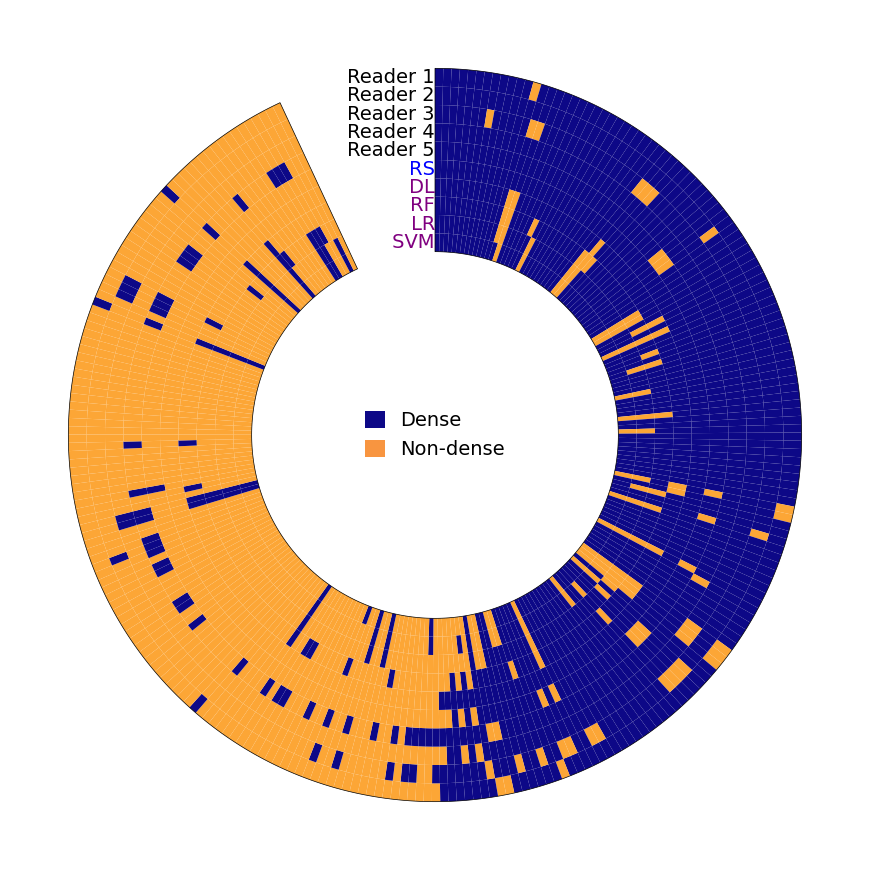

In [19]:
sectors = {"A": 258}
circos = Circos(sectors, end=340, space=5)
vmin2, vmax2 = 0, 1.25
for sector in circos.sectors:
    # Plot heatmap 
#     track1 = sector.add_track((80, 100))
#     track1.axis()
#     track1.xticks_by_interval(1)
#     data = np.random.randint(vmin1, vmax1 + 1, (4, int(sector.size)))
#     track1.heatmap(data, vmin=vmin1, vmax=vmax1, show_value=True)
    # Plot heatmap with labels
    track2 = sector.add_track((50, 100))
    track2.axis()
#     x = np.linspace(1, int(track2.size), int(track2.size)) - 0.5
#     xlabels = [str(int(v + 1)) for v in x]
#     track2.xticks(x, xlabels, outer=False)
#     track2.yticks([0.5, 1.5, 2.5, 3.5, 4.5], list("ABCDE"), vmin=0, vmax=5)
    #data = np.random.randint(vmin2, vmax2 + 1, (5, int(sector.size)))
    data = np.vstack((l_1_b,l_2_b,l_3_b,l_4_b,l_5_b, consensus_2, dl_2,  y_pred_rf_2, y_pred_lr_2, y_pred_svm_2))
    data = data[::, data[5,].argsort()]
    heatmap_2 = track2.heatmap(data, vmin=vmin2, vmax=vmax2, cmap="plasma")#rect_kws=dict(ec="white", lw=1))

#circos.colorbar(bounds=(0.35, 0.55, 0.3, 0.01), vmin=vmin1, vmax=vmax1, orientation="horizontal")
# circos.colorbar(bounds=(0.35, 0.45, 0.3, 0.01), vmin=vmin2, vmax=vmax2, orientation="horizontal", cmap="viridis")

    text_common_kws = dict(ha="right", va="center", size=14)
    circos.text(" Reader 1", r=97.5,  **text_common_kws)
    circos.text(" Reader 2", r=92.5,  **text_common_kws)
    circos.text(" Reader 3", r=87.5,  **text_common_kws)
    circos.text(" Reader 4", r=82.5,  **text_common_kws)
    circos.text(" Reader 5", r=77.5,  **text_common_kws)
    circos.text(" RS", r=72.5, color="blue", **text_common_kws)
    circos.text(" DL", r=67.5, color="purple", **text_common_kws)
    circos.text(" RF", r=62.5, color="purple", **text_common_kws)
    circos.text(" LR", r=57.5, color="purple", **text_common_kws)
    circos.text(" SVM", r=52.5, color="purple", **text_common_kws)

fig = circos.plotfig()


cmap = plt.cm.get_cmap("plasma")

from matplotlib.patches import Patch

_ = circos.ax.legend(
    handles=[
        Patch(color=cmap(0), label="Dense"),
        Patch(color=cmap(0.75), label="Non-dense"),
    ],
    bbox_to_anchor=(0.5, 0.5),
    loc="center",
    fontsize=14,
    ncols=1,
)

plt.savefig('circos_2.tiff', dpi = 600)

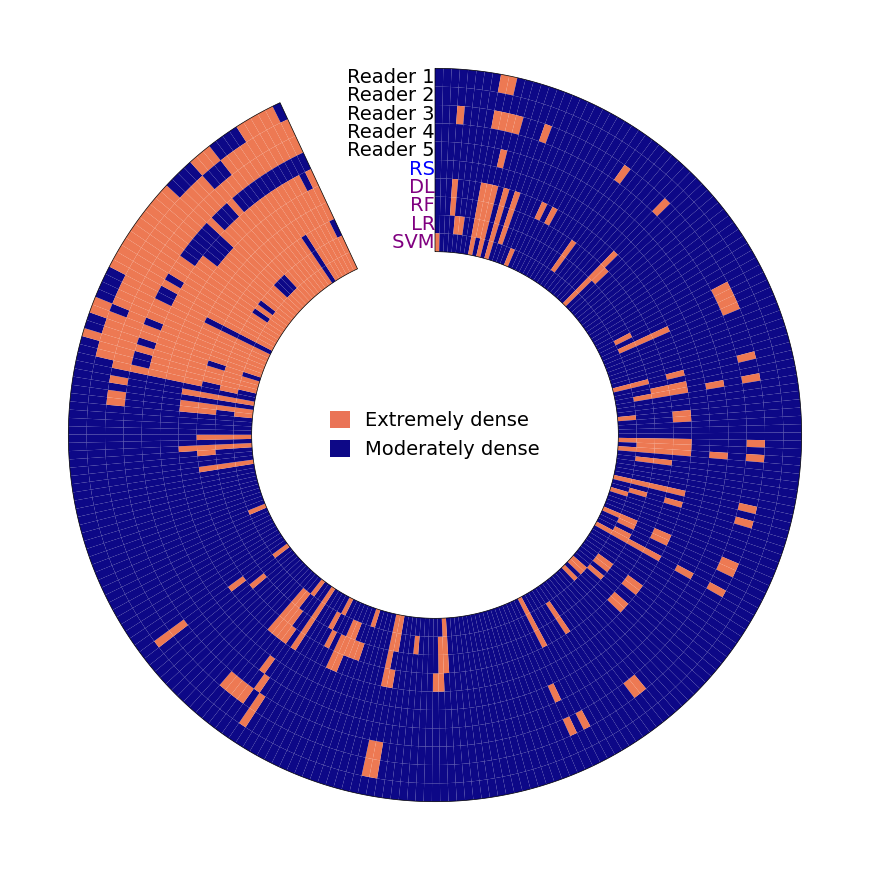

In [21]:
y_prob_test_dl_exd = DL_pred_4.Probility_3.values

dl_exd_pred = np.array([1 if x >= 0.26174977 else 0 for x in y_prob_test_dl_exd])

sectors = {"A": 258}
circos = Circos(sectors, end=340, space=5)
vmin2, vmax2 = 0, 1.5
for sector in circos.sectors:
    # Plot heatmap 
#     track1 = sector.add_track((80, 100))
#     track1.axis()
#     track1.xticks_by_interval(1)
#     data = np.random.randint(vmin1, vmax1 + 1, (4, int(sector.size)))
#     track1.heatmap(data, vmin=vmin1, vmax=vmax1, show_value=True)
    # Plot heatmap with labels
    track2 = sector.add_track((50, 100))
    track2.axis()
#     x = np.linspace(1, int(track2.size), int(track2.size)) - 0.5
#     xlabels = [str(int(v + 1)) for v in x]
#     track2.xticks(x, xlabels, outer=False)
#     track2.yticks([0.5, 1.5, 2.5, 3.5, 4.5], list("ABCDE"), vmin=0, vmax=5)
    #data = np.random.randint(vmin2, vmax2 + 1, (5, int(sector.size)))
    data = np.vstack((l_1_exd,l_2_exd,l_3_exd,l_4_exd,l_5_exd, consensus_exd, dl_exd_pred, pred_exd['RF'], pred_exd['LR'], pred_exd['SVM']))
    data = data[::, data[5,].argsort()]
    heatmap_2 = track2.heatmap(data, vmin=vmin2, vmax=vmax2, cmap="plasma")#rect_kws=dict(ec="white", lw=1))

#circos.colorbar(bounds=(0.35, 0.55, 0.3, 0.01), vmin=vmin1, vmax=vmax1, orientation="horizontal")
# circos.colorbar(bounds=(0.35, 0.45, 0.3, 0.01), vmin=vmin2, vmax=vmax2, orientation="horizontal", cmap="viridis")

    text_common_kws = dict(ha="right", va="center", size=14)
    circos.text(" Reader 1", r=97.5,  **text_common_kws)
    circos.text(" Reader 2", r=92.5,  **text_common_kws)
    circos.text(" Reader 3", r=87.5,  **text_common_kws)
    circos.text(" Reader 4", r=82.5,  **text_common_kws)
    circos.text(" Reader 5", r=77.5,  **text_common_kws)
    circos.text(" RS", r=72.5, color="blue", **text_common_kws)
    circos.text(" DL", r=67.5, color="purple", **text_common_kws)
    circos.text(" RF", r=62.5, color="purple", **text_common_kws)
    circos.text(" LR", r=57.5, color="purple", **text_common_kws)
    circos.text(" SVM", r=52.5, color="purple", **text_common_kws)

fig = circos.plotfig()


cmap = plt.cm.get_cmap("plasma")

from matplotlib.patches import Patch

_ = circos.ax.legend(
    handles=[
        Patch(color=cmap(0.65), label="Extremely dense"),
        Patch(color=cmap(0.0), label="Moderately dense"),
    ],
    bbox_to_anchor=(0.5, 0.5),
    loc="center",
    fontsize=14,
    ncols=1,
)

plt.savefig('circos_exd.tiff', dpi = 600)